###### ДЗ 2 Кластеризация 

*Креативная часть:* Релизовать на питоне ДЗ от вашего преподователя по МО

*Техническая часть:* сделать под это всё удобные обёртки. Например, это функция, которая просто принимает список фичей, а на выходе показывает результат фита

## Постановка задачи

Необходимо разбить игроков на группы по прогрессу, чтобы в дальнейшем формировать сбалансированные команды.
Предполагаю получить группы с **сильными**, **средними** и **слабыми** игроками, но возможны и другие разбиения.

Ввиду предварительного анализа могу сказать, что разбиение игроков на роли по этим данным тоже реально. Но для этой задачи очень сложно просчитать фичу, которую можно было бы использовать в классификации. Мне не хочется пытаться предсказать номера кластеров в классификации, потому что это не добавит точности модели, а это не очень интересно.

я хочу поделить игроков на 3 уровня владения игрой + отобрать кандидатов на бан за читерство

## Структура тетради
1. **Анализ датасета:** в этом разделе происходит дознание имеющихся данных. Это актуально, так как источник не оставил исчерпывающего описания.
2. **Отбор фичей:** в этом разделе будет происходит анализ взаимосвязи фичей и отбор тех, которые будут участвовать в кластеризации. Также будет определена фича для классификации.
3. **Кластеризация:** в этом разделе речь пойдет о выбранном алгоритме кластеризации, CURE, его особенностях, параметрах, способах использования и реализация данного метода на данных.
4. **Классификация:** в этом разделе на основе выделенных кластеров была проведена классификация и сделаны выводы о различие методов обучения с учителем и без него.

После каждого раздела следует бок с выводами, число в заголовке отражает номер раздела, которому они соответсвуют.

## Ссылка на данные
Источник данных: https://www.kaggle.com/code/aishahakami/starter-call-of-duty-players-skills-0b551a7c-7

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model, model_selection, preprocessing
from sklearn.preprocessing import OrdinalEncoder
from pyclustering.cluster.cure import cure
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
# from clustergram import Clustergram

def show_scatter(x,y, xLabel, yLabel):
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)    
    plt.scatter(x, y)
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x),"r--")
    plt.show()

def show_scatter_for_all(df, x_label):
    for column in df.columns.values:
        show_scatter(df[x_label], df[column], x_label, column)
   
    
def dfToSample(df):
    rec = df.to_records(index=False)
    df.to_csv('./pandas2.txt', header=None, index=None, sep=' ', mode='w+')
    path= './pandas2.txt'
    sample = read_sample(path)
    return sample

def cureClustering(df, clusters_number, number_r = 5, comp = 0.5):
    cure_instance = cure(dfToSample(df), clusters_number, number_represent_points = number_r, compression = comp)
    cure_instance.process()
    
    clusters = cure_instance.get_clusters()
    clustersLen = [len(cluster) for cluster in clusters]
    
    print(clustersLen)
    return clusters

def drop_emissions(df, k_num, c_num, alpha, min_k_len):
    clust = cureClustering(df, k_num, c_num, alpha)
    err = []
    
    for k in clust:
        if len(k) <= min_k_len:
            err.extend(k)
    print(err)
    
#     df.drop(err, inplace = True)
    
    return err

def find_emissions(df, k_num):
    for i in range(1, 11):
        print('alpha = ', i/10)
        for j in range(3, 35, 3):
#             print('c = ', j*5+1)
            clust = cureClustering(df, k_num, j, i/10)


def elbowKM(df, n):
    distortions = []
    K = range(1,n)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
    #     cureModel = cureClustering(dff, 20)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'b*-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
def accuracy_percent(x_train, y_train, x_test, y_test, classification_model): #
    classification_model.fit(x_train, y_train)
    y_pred = classification_model.predict(x_test)
    
    print(f'{classification_model}\nScore is {classification_model.score(x_train, y_train)*100}%')
    
def class_predict(feature_value_str, classification_model, scaler): #
    data_scaled = scaler.transform(feature_value_str)
    class_ = classification_model.predict(data_scaled)
    pred_class = classes_dict[class_[0]]
    
    print(f'Predicted class: {pred_class}')
    
    return pred_class

### 1 АНАЛИЗ ДАТАСЕТА

In [2]:
FILEPATH = "./cod.csv"

df_cod = pd.read_csv(FILEPATH).dropna()

В результате безумно долгого и мучительного анализа предоставленных данных был выявлен ряд интересных и даже удручающих обстоятельств, которые заставили сильно задуматься при отборе фичей.
1. **Call of Duty: Modern Warfare 2019 года имеет единую систему престижей с другими играми.** \
В частности, между **Modern Warfare, Warzone, Black Ops Cold War и Vanguard** существует синхронизация боевых пропусков и **престижей**. Из этого следует, что **prestige** сам по себе вполне может отражать общий уровень опыта и мастерства игрока. Кроме того, престиж в последних версиях игры был заменен на сезонные офицерские звания (датасет был залит год назад, данные должны быть новыми).\
[ист.: https://vk.com/wall-164212374_123270 \
https://stopgame.ru/newsdata/45560/o_edinoy_sisteme_progressa_v_black_ops_cold_war_warzone_i_modern_warfare ]
2. **Престиж можно не прокачивать.**
Наряду с тем, что игрок может получать сезонные звания у него существует возможность не прокачивать их. Так было в предыдущих версиях игры, но в этой версии такого не должно быть, проверим.
3. **После получения нового уровня престижа обнуляются все достижения**
Такое действиетльно было в предыдущих версиях игры, но на данный момент от этого было решено уйти, на форумах пишут, что теперь 1-55 уровни никогда не обнуляются. Тогда все игроки с уровнем ниже 55 и любым уровнем престижа мигрировали в эту игру из другой.\
[ист.: https://www.igromania.ru/news/87353/Bolshe_bez_prestizhey_v_Call_of_Duty_Modern_Warfare_izmenitsya_sistema_progressa.html ]
4. **Метрики отражают прогресс игрока не только в мультиплеере, но и в одиночном режиме**
Существуют ли метрики, которые заполняются только в одном режиме игры?
5. **Общее число игр может отличаться от суммы побед и поражений**
Как минимум 1 режим позволяет заканчивать раунд ничьей, но бывают случаи, когда общее число игр меньше суммы побед и поражений. Полгаю, что такое возможно, например, если игрок покинул игру досрочно, ему могли не засчитать участие в матче, но какую то статистику он получил.\
[ист.: https://cubiq.ru/call-of-duty-modern-warfare-vse-chto-izvestno-ob-igre/ поиск по слову "ничья"]

Проверим предположения: 
1. игроки с высоким престижем могут иметь любой уровень
2. после получения нового престижа статистика не обнуляется
4. есть параметры, которые заполняются всегда, а есть те, которые заполняются только в мультиплеере
3. игроки могут не прокачивать престиж

In [3]:
# предположение 1
df_cod[(df_cod['prestige'] > 1) & (df_cod['level'] == 1) ].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000
mean,0.160000,1.400000,0.187824,0.120000,1.0,0.080000,86.400000,1.02000,3.060000,0.260000,2.980000,0.060000,0.960000,13.700000,995.500000,7.541500,14.72000,7.640000
std,0.888934,2.222336,0.295261,0.593846,0.0,0.274048,40.507495,5.05678,3.909225,0.564602,3.846493,0.313636,1.603058,77.271388,1021.315803,37.432986,81.59908,9.314812
min,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,53.750000,0.00000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,25.000000,0.000000,0.00000,0.250000
50%,0.000000,0.500000,0.015625,0.000000,1.0,0.000000,110.000000,0.00000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,700.000000,0.000000,0.00000,4.500000
75%,0.000000,2.000000,0.237500,0.000000,1.0,0.000000,110.000000,0.00000,4.750000,0.000000,4.000000,0.000000,2.000000,0.000000,1550.000000,0.000000,0.00000,10.750000
max,6.000000,11.000000,1.000000,3.000000,1.0,1.000000,110.000000,27.00000,19.000000,2.000000,19.000000,2.000000,8.000000,526.000000,3450.000000,202.875000,550.00000,40.000000


**Что видно:** средний уровень престижа 86, средние значения всех показателей и 75% близки к минимальным\
**Вывод:** на 1 уровне вся статистика имеет показатели близкие к начальным, обнуление может быть, а может и не быть, но совершенно точно, при переходе из другой игры статистика не переносится, только престиж.\
Т.о. **предположение 1 верно**\
а **предположение 2 невозможно проверить**, так как обнуление подразумевает сброс уровня в том числе

Необходимо дознание.\
Проверим статистику более высоких уровней

In [4]:
# предположение 3
df_cod[(df_cod['prestige'] > 1) & (df_cod['level'] > 5) & (df_cod['level'] < 20)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,19.910828,220.286624,0.683255,3.866242,11.477707,2.363057,65.464968,609.229299,62.808917,38.904459,33.454779,8.133758,47.356688,3147.808917,70163.700637,83.528255,3757.038217,320.961783
std,27.778745,244.402491,0.266246,4.266890,4.141079,2.677429,49.045835,1007.160351,43.490809,42.057620,40.712878,13.764547,54.979252,5106.565500,38243.427007,111.064817,6054.996241,343.439986
min,0.000000,14.000000,0.160000,0.000000,6.000000,0.000000,2.000000,0.000000,8.000000,0.000000,1.666667,0.000000,0.000000,0.000000,22550.000000,0.000000,0.000000,23.000000
25%,0.000000,54.000000,0.481928,0.000000,8.000000,0.000000,10.000000,0.000000,32.000000,10.000000,4.250000,0.000000,5.000000,0.000000,36700.000000,0.000000,0.000000,97.000000
50%,10.000000,119.000000,0.662252,2.000000,11.000000,1.000000,110.000000,35.000000,51.000000,21.000000,23.000000,1.000000,31.000000,358.000000,60414.000000,7.159322,384.000000,214.000000
75%,29.000000,279.000000,0.864198,7.000000,15.000000,4.000000,110.000000,796.000000,77.000000,50.000000,50.000000,11.000000,72.000000,4124.000000,104747.000000,164.925000,4701.000000,362.000000
max,159.000000,1179.000000,1.413793,16.000000,19.000000,12.000000,111.000000,4528.000000,316.000000,197.000000,316.000000,76.000000,293.000000,28128.000000,151660.000000,389.850000,32198.000000,2072.000000


**Видим:** статистика заметно отличается от 1 уровня, минимальное время игры = 8 ч, 25% не играли ни одной игры (победы и поражения = 0), 25% имеют 0 по killstreak, hits, misses, scorePerMinute и shots.\
Необходимо дознание

In [5]:
df_cod[(df_cod['wins'] == 0) & (df_cod['losses'] == 0)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,462.0,462.000000,462.000000,462.000000,462.000000,462.0,462.000000,462.000000,462.000000,462.000000,462.000000,462.0,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,0.0,10.062771,0.216861,0.002165,2.298701,0.0,25.703463,0.006494,9.714286,1.800866,9.714286,0.0,2.305195,0.177489,8699.484848,0.641169,0.183983,21.417749
std,0.0,37.371245,0.344484,0.046524,3.448656,0.0,45.941734,0.103941,30.431969,5.522127,30.431969,0.0,8.690879,3.412191,37221.253121,9.992585,3.423588,53.375687
min,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,200.000000,0.000000,0.000000,2.000000
75%,0.0,5.750000,0.380114,0.000000,2.000000,0.0,14.000000,0.000000,8.000000,1.000000,8.000000,0.0,0.000000,0.000000,5283.250000,0.000000,0.000000,16.750000
max,0.0,686.000000,3.000000,1.000000,47.000000,0.0,111.000000,2.000000,516.000000,88.000000,516.000000,0.0,84.000000,73.000000,706455.000000,194.400000,73.000000,666.000000


In [6]:
# можно спихнуть такие показатели на заполнение (человек не доиграл, но статистика засчиталась)
df_cod[(df_cod['wins'] == 0) & (df_cod['losses'] == 0) & (df_cod['scorePerMinute'] == 194.400000)]

,name,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
161,NainFéroce#4542111,0,1,0.083333,1,1,0,0,1,1,0,1.0,0,0,2,550,194.4,3,12


In [7]:
# всего 2 записи, но они весьма показательны
df_cod[(df_cod['level'] > 20) & (df_cod['wins'] == 0) & (df_cod['losses'] == 0)]

,name,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
1163,eren#3417253,0,686,1.030030,0,47,0,110,0,516,88,516.0,0,84,0,706455,0.0,0,666
1328,PowerLJR#9902279,0,140,0.848485,0,23,0,110,0,82,13,82.0,0,2,0,192950,0.0,0,165


**Вывод: killstreak, hits, misses, scorePerMinute и shots заполняются во время игры в мультиплеер**.\
**Т.о. предположение 3 подтвердилось**, часть характеристик заполняются только в мультиплеере

In [8]:
# предположение 4
df_cod[(df_cod['prestige'] < 1)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.0,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000,609.000000
mean,4.816092,72.458128,0.336358,1.957307,3.172414,1.049261,0.0,254.991790,12.162562,11.735632,4.260611,3.287356,15.190476,1237.510673,13862.371100,74.696403,1492.502463,103.706076
std,11.285281,192.733484,0.403830,3.518020,4.093258,2.184169,0.0,740.043196,22.520419,31.483508,7.590749,9.050181,41.600621,3322.114744,29651.308666,117.163107,4040.348849,250.480730
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.200000,0.000000,1.000000,0.000000,0.0,0.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1225.000000,0.000000,0.000000,9.000000
75%,4.000000,30.000000,0.583333,3.000000,4.000000,1.000000,0.0,64.000000,14.000000,6.000000,4.000000,1.000000,4.000000,445.000000,12675.000000,152.400000,521.000000,60.000000
max,90.000000,1980.000000,3.000000,26.000000,27.000000,15.000000,0.0,7532.000000,178.000000,278.000000,57.000000,82.000000,334.000000,28682.000000,256346.000000,413.800000,36214.000000,1983.000000


In [9]:
df_cod[(df_cod['level'] > 55)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,3.580000e+02,358.000000,3.580000e+02,358.000000
mean,548.458101,14225.773743,0.990325,16.382682,151.547486,12.952514,93.019553,38442.175978,1545.008380,2377.603352,34.475524,428.567039,2566.709497,167466.662011,3.345296e+06,162.147933,2.059084e+05,14423.430168
std,420.709588,11221.579557,0.206609,15.604762,68.031684,8.980557,33.691751,34695.193747,992.202751,1811.979515,145.602147,387.937987,2284.968902,145070.098661,2.434581e+06,92.584614,1.780965e+05,11265.324540
min,0.000000,838.000000,0.501559,0.000000,56.000000,1.000000,1.000000,0.000000,283.000000,145.000000,1.538043,0.000000,17.000000,0.000000,9.700790e+05,0.000000,0.000000e+00,940.000000
25%,268.000000,6841.000000,0.883268,12.000000,98.000000,8.000000,102.500000,14266.000000,857.250000,1138.750000,2.457755,178.500000,1071.000000,63661.250000,1.496146e+06,87.178556,8.263150e+04,6863.250000
50%,468.500000,10587.000000,0.967244,14.000000,142.000000,11.000000,111.000000,29166.000000,1258.500000,1859.000000,3.343674,339.500000,1911.000000,132217.000000,2.486650e+06,172.150069,1.639725e+05,11102.500000
75%,684.000000,19289.750000,1.063704,18.000000,186.750000,15.000000,111.000000,51412.500000,2019.000000,3223.500000,6.342091,597.750000,3481.750000,230516.750000,4.346362e+06,239.547535,2.857822e+05,18766.500000
max,3519.000000,66935.000000,2.171183,235.000000,435.000000,80.000000,117.000000,209851.000000,7479.000000,11719.000000,1349.000000,3745.000000,14531.000000,965775.000000,1.497054e+07,332.842222,1.166620e+06,67888.000000


**Видим:** Максимальный уровень игрока с престижем 0 составляет 27, а минимальный престиж игроков с уровнем выше 55 составляет 1.\
**Вывод:** у игроков нет выбора в получении сезонных званий.\
**Т.о. предположение 4 не подтвердилось**

### 1 ВЫВОДЫ
1. Для анализа игроков мультиплеера необходимо обращаться к данным в разрезе переменных wins, losses, killstreak, hits, misses, scorePerMinute и shots
2. level отражает приверженность пользователя к данной игре, prestige отражает его прогрессивность

### 2 ОТБОР ФИЧЕЙ

Итак, что может быть полезно для анализа: 
   1. prestige -- отражает прогрессивность, опытность игрока
   2. level -- эквивалент прогрессивности и опыта игрока в рамках игры
   3. timePlayed -- также эквивалент опыта игрока, часы, которые он потратил в игре
   4. xp -- очки опыта -- может быть очень показательным во взаимодействии со временем и уровнем
   5. **scorePerMinute** -- очки опыта в минуту во время игры в мультиплеер
   6. **wins** -- количество побед в мультиплеере -- во взаимодействии с поражениями или общим количеством матчей может помогать выявить игроков, которые часто выигрывают, следовательно, имеют большой игровой опыт, развитые навыки в рамках своей роли, лидерские качества
   7. **losses** -- количество поражений в мультиплеере
   8. kills -- общее число убийств
   9. deaths -- общее число смертей
   10. kdRatio = kills/deaths -- популярный важный показатель результативности игрока
   11. **killstreak** -- неприрывная серия убийств, сколько убийств совершил игрок до своей смерти в мультиплеере
   12. assists -- общее число убийств, которые игрок "помог" совершить
   13. headshots -- общее число попаданий в голову
   14. **hits** -- попадания в игрока во время игры в мультиплеер
   15. **misses** -- промахи во время игры в мультиплеер
   16. **shots** = hits + misses -- число выстрелов в мультиплеере не считая хедшотов
    
    
Фичи, которые не имеют достаточной семантической ценности:
   1. name -- имя игрока
   2. averageTime = timePlayed/gamesPlayed -- не имеет однозначной трактовки, просто время деленное на количество матчей
   3. gamesPlayed -- количество сыгранных матчей, неизвестный характер заполнения данной фичи сделал ее нецелесообразной в использовании
    

Мы пытаемся разбить игроков для формирования команд, поэтому игроки, чьи профили не заполнены по важным для командной игры показателям (они были выделенны) будут убраны из основной выборки. Дальнейшее из рассмотрение считаю нецелесообразным, так как по мере того, как их данные будут заполняться, они станут пригодны для анализа.

Оценивать нужно в разрезе времени и уровня: те, кто только перешел на платформу могут быть прогрессивными, не смотря на маленькие показатели в столбце времени и уровня.

Чтобы выделять взаимодействия было проще, построим корреляционную матрицу.

Сначала избавимся от тех профилей, которые не играли в мультиплеер.

In [10]:
df = df_cod.drop(['name'], axis=1)
df = df.drop(['averageTime'], axis=1)
df["gamesPlayed"] = df["wins"] + df["losses"]

dfWMG = df[(df["gamesPlayed"] == 0)] # df without multiplayer games на всякий случай решила сохранить
df.drop(dfWMG.index, inplace = True)

dfWMG.describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,462.0,462.000000,462.000000,462.000000,462.000000,462.0,462.000000,462.000000,462.000000,462.000000,462.0,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,0.0,10.062771,0.216861,0.002165,2.298701,0.0,25.703463,0.006494,9.714286,1.800866,0.0,2.305195,0.177489,8699.484848,0.641169,0.183983,21.417749
std,0.0,37.371245,0.344484,0.046524,3.448656,0.0,45.941734,0.103941,30.431969,5.522127,0.0,8.690879,3.412191,37221.253121,9.992585,3.423588,53.375687
min,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,200.000000,0.000000,0.000000,2.000000
75%,0.0,5.750000,0.380114,0.000000,2.000000,0.0,14.000000,0.000000,8.000000,1.000000,0.0,0.000000,0.000000,5283.250000,0.000000,0.000000,16.750000
max,0.0,686.000000,3.000000,1.000000,47.000000,0.0,111.000000,2.000000,516.000000,88.000000,0.0,84.000000,73.000000,706455.000000,194.400000,73.000000,666.000000


К сожалению, да, треть профилей никогда не доводили матч до конца.

In [11]:
df.describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.000000,1.096000e+03,1096.000000
mean,217.498175,5330.773723,0.814242,9.801095,62.167883,7.104927,56.911496,14684.701642,601.358577,895.762774,224.603102,973.911496,64475.923358,1.236810e+06,153.068805,7.916049e+04,5499.977190
std,340.045616,9000.399804,0.328018,10.908362,74.617350,7.403130,51.108984,26176.181770,880.101572,1478.144114,344.345990,1731.472020,111354.384979,2.033978e+06,111.217836,1.367910e+05,9051.314335
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000
25%,7.000000,127.750000,0.634708,4.000000,8.000000,2.000000,0.000000,109.750000,31.000000,21.000000,9.000000,21.000000,662.250000,3.914300e+04,35.323947,7.745000e+02,187.000000
50%,68.000000,1202.500000,0.872971,9.000000,30.000000,6.000000,45.000000,2912.000000,215.500000,203.500000,76.000000,220.500000,13973.500000,3.219805e+05,163.336995,1.639700e+04,1430.000000
75%,288.250000,6722.000000,0.999610,14.000000,94.000000,10.000000,110.000000,18041.750000,843.750000,1131.250000,299.000000,1122.250000,80254.000000,1.444248e+06,250.404464,1.001278e+05,6863.250000
max,3519.000000,66935.000000,2.500000,235.000000,435.000000,80.000000,117.000000,209851.000000,7479.000000,11719.000000,3539.000000,14531.000000,965775.000000,1.497054e+07,413.800000,1.166620e+06,67888.000000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


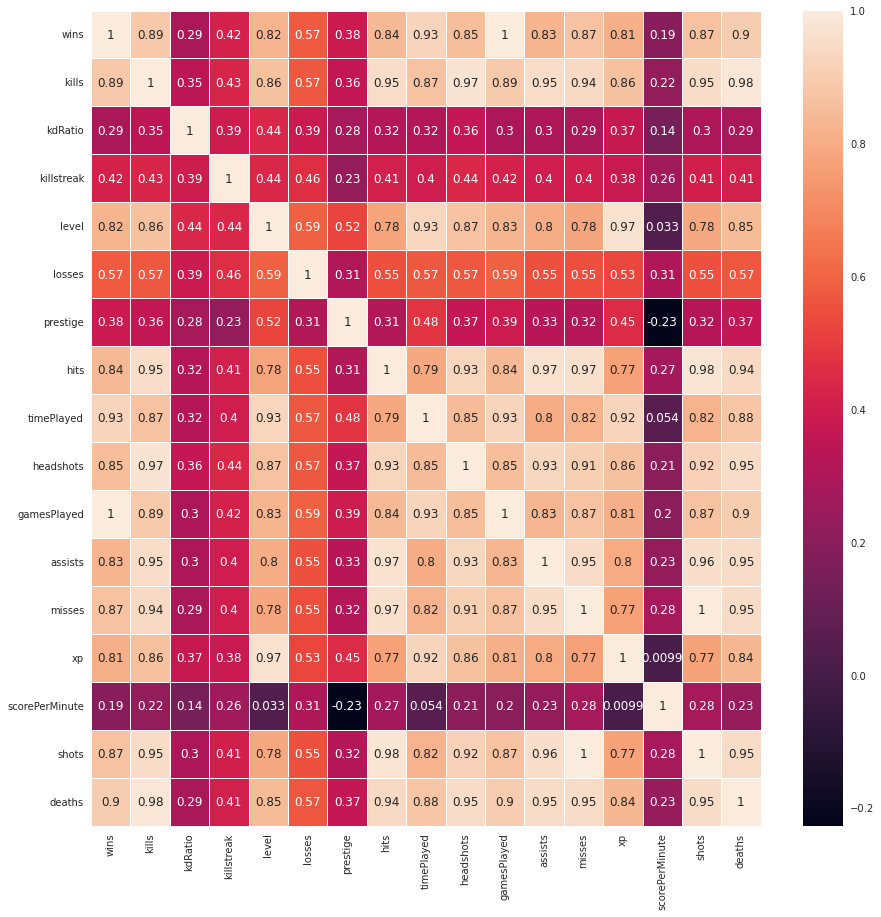

In [12]:
plt.subplots(figsize=(15,15))
cl = sns.heatmap(df.corr(),annot=True, linewidths = 1)
plt.show()

Видно, что **level** и **prestige** коррелируют со всеми показателями, но престиж в меньшей степени, что очевидно (из-за системы итеграции игроков с других платформ). Это и семантика показателей заставляют отказаться от использования их в чистом виде, но имеено взаимодействие этих фактор в целом и отражает степень прогрессивности игроков, поэтому ее я буду использовать для классификации.

**kdRatio** и **scorePerMinute** практически не коррелируют с другими, их оставим неизменными, а все остальное заменим на взаимодействия.

Введем новые параметры:
1. **WinLose = wins/losses** -- как часто выигрывает пользователь\
минус: относительная величина, 1/2 относится также как 100/200, не передает опыт
2. **xpRatio = xp/timePlayed** -- скорость набора очков игроком в минуту\
минус: коррелирует с kdRato, но это семантически разные факторы\
плохо отражает реальную скорость, усредняет весь прогресс
3. **kaRatio = kills/assists** -- как часто игрок доводил убийства до конца\
минус: странно себя ведет на графиках, у большиства это низкий показатель, возможно не несет серьезного смысла, но может помочь выявлять выбросы\
не помогает отделить плохих игроков от хороших, аналогично WinLose
4. **hmRatio = hits/misses** -- результативность выстрелов игрока в матче\
минус: здесь лучше сомтрелись бы хедшоты, но их сложно учесть, т.к. они заполняются по результатам не только мультиплеера\
коррелирует с kd
5. **khRatio = kills/headshots** -- как часто хедшоты приводят к смертям\
минус: показатель относительный\
также отражает и уровень пользователя, уровень оружия пользователя

Также будут использоваться факторы в чистом виде:

6. **kdRatio**

7. **scorePerMinute**

8. **killstreack**

9. ставить ли время?

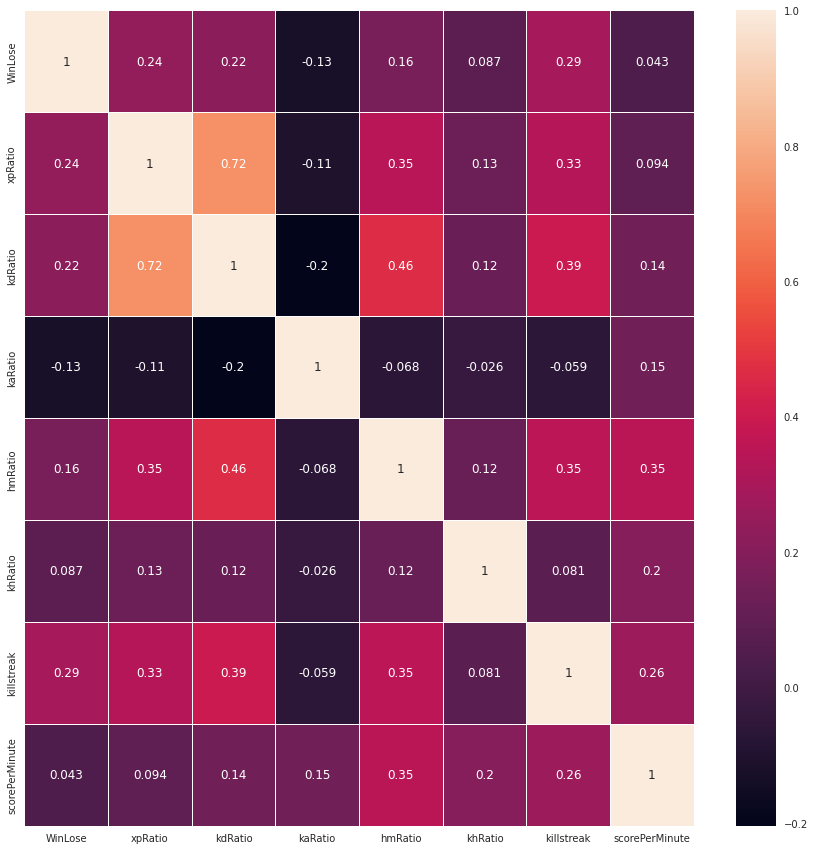

In [13]:
dfFE = df

dfFE['WinLose'] = dfFE['wins']/dfFE['losses'].replace(0, 1)               # убрать в чистом виде
dfFE["xpRatio"] = dfFE["xp"] / (dfFE["timePlayed"]*60)                   # xp убрать, time? 
dfFE["kaRatio"] = dfFE["assists"] /dfFE["kills"].replace(0, 1)            # убрать
dfFE["hmRatio"] = dfFE["hits"] /dfFE["misses"].replace(0, 1)              # убрать их и shots
dfFE["khRatio"] = dfFE["kills"] /dfFE["headshots"].replace(0, 1)          # убрать

clusterColumns = ['WinLose', 'xpRatio', 'kdRatio', 'kaRatio', 'hmRatio', 'khRatio', 'killstreak', 'scorePerMinute']
dfT = dfFE[clusterColumns] # df test

plt.subplots(figsize=(15,15))
cl = sns.heatmap(dfT.corr(),annot=True, linewidths = 1)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


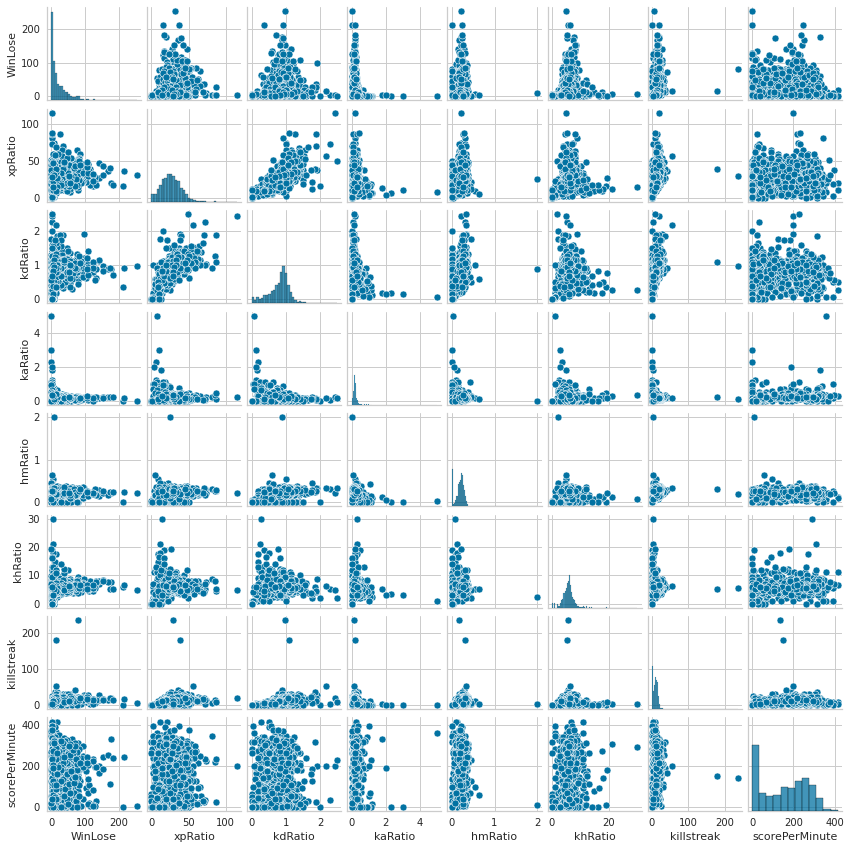

In [14]:
sns.pairplot(dfT, height=1.5)

Интересно проверить как фичи ведут себя в разрезе количества матчей, так как именно по данному покзаателю была разеделна выборка

In [15]:
# show_scatter_for_all(dfFE, 'gamesPlayed')

Видно, что при gamesPlayed равном [0 - 2] некоторые фичи ведут себя схоже.\
В частности, khRatio и kaRatio, -- выборку можно поделить на две части, поэтому, все же, придется повысить планку и анализировать только тех, кто сыграл хотя бы 3 матча. 

In [16]:
# df = df_cod.drop(['name'], axis=1)
# df = df.drop(['averageTime'], axis=1)
# df["gamesPlayed"] = df["wins"] + df["losses"]

# dfWMG = df[(df["gamesPlayed"] < 3)] # df without multiplayer games на всякий случай решила сохранить
# df.drop(dfWMG.index, inplace = True)

# dfFE = df

# dfFE['WinLose'] = dfFE['wins']/dfFE['losses'].replace(0, 1)               # убрать в чистом виде
# dfFE["xpRatio"] = dfFE["xp"] / (dfFE["timePlayed"]*60)                   # xp убрать, time? 
# dfFE["kaRatio"] = dfFE["assists"] /dfFE["kills"].replace(0, 1)            # убрать
# dfFE["hmRatio"] = dfFE["hits"] /dfFE["misses"].replace(0, 1)              # убрать их и shots
# dfFE["khRatio"] = dfFE["kills"] /dfFE["headshots"].replace(0, 1)          # убрать

# dfT = dfFE[['WinLose', 'xpRatio', 'kaRatio', 'hmRatio', 'khRatio', 'killstreak', 'scorePerMinute']] # df test
# sns.pairplot(dfT, height=1.5)

In [17]:
# show_scatter_for_all(dfFE, 'gamesPlayed')

## 2 ВЫВОД
Был сформирован набор факторов, каждый из которых с той или иной стороны отражает прогресс игрока на выбранной платформе в отрыве от времени и уровня. Иной подход был бы некорректен, так как существует система интеграции прогресса с другими платформами. 

Все факторы имеют нормальное или близкое к нормальному распределение. Присутсвует сильная дисперсия и объекты, похожие на выбросы. Выявить какую-то явную зависимость между факторами нельзя. Какие то дополнительные преобразования на данном этапе будут беспочвенны, поэтому можно переходить к кластеризации.

## 3 КЛАСТЕРИЗАЦИЯ

**Алгоритм кластеризации CURE.**

**CURE** — это алгоритм агломерационной иерархической кластеризации, который создает баланс между центроидом и всеми точечными подходами. Он более устойчив к выбросам, и идентифицирует кластеры, имеющие несферическую форму, s-образную форму и т.д. и большие различия в размере. Данный метод предназначен для анализа больших данных. Также экспериментально подтверждено, что качество кластеров, созданных CURE, намного лучше, чем у многих других алгоритмов, например, k-means, BIRCH, MST. 

Если говорить кратко, то суть метода в следующем:

Первый этап.

1.	Создается случайная выборка из полного набора данных для создания некоторых «представлений» кластеров, это необходимо для того, чтобы данные могли уместиться в памяти;
2.	Посредством агломеративного иерархичесского дерева с использованием евклидовых расстояний на случайной выборке создаются кластеры;
3.	В рамках каждого кластера выделяются репрезентативные точки;
    a.	Репрезентативные точки – это точки, которые максимально удалены друг от друга в рамках одного кластера, первая репрезентативная точка всегда является точкой, наиболее удаленной от центроида кластера;
4.	На основе данных, полученных о репрезентативных точках, создаются синтетические точки, которые имеют координаты более близкие к центроиду, можно сказать, что синтетические точки, это репрезентативные, но сдвинутые к центроиду на некоторую долю, от 0 до 1 (как от 0 до 100%); обычно это 20%, но по умолчанию в питоне стоит 50%;
5.	Информация о репрезентативных (синтетических) точках кластеров сохраняется.\

Второй этап.

1.	Репрезентативные точки «накладываются» на реальные данные;
2.	Каждая точка «сканируется» и определяется в тот кластер, репрезентативная точка которого к ней ближе всего. Для определения расстояний между точками используется евклидово расстояние.

Таким образом входными параметрами для алгоритма служат: **$S$** -- набор входных данных, содержащий $n$ точек в $d$-мерном пространстве и желаемое количество кластеров **$k$**. Можно также задавать другие дополнительные параметры, например, **$с$** -- количество репрезентативных точек \
и **$\alpha$** -- коэффициент сжатия.

[ист.: статья https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.83.1599&rep=rep1&type=pdf ]

**Применение алгоритма к данным**

Этот алгоритм должен хорошо проявить себя на выборке так как:
1. нет предположений о формах и размерах кластеров
2. нет предположений о возможных выбросах, а данный алгоритм как рах может использоваться для их выявления

Кроме того, данный метод не требует нормального распределения данных и может быть использован для работы с большим количеством данных.

Метод также выделяет выбросы в отдельные кластеры, в связи с чем мною был сформриован подход для кластеризации с учетом обхода выбросов.
Суть моего подхода в том, чтобы кластеризировать на зведомо большее количество кластеров чтобы выявить выбросы за минимальное количество итераций. 
Что касается подбора параметров, то тут я скорее основываюсь на уже полученном опыте работы метода на этих данных. В основном выделяется один большой кластер и несколько гораздо более меньших. Чтобы это избежать, в алгоритм будут передаваться значения:
1. **porog** объем кластера, который будет считаться достаточным для его рассмотрения (150 объектов)\
т.е. кластеры с таким объемом можно будет рассматривать для анализа.\
небольшое трехзначное число оказалось подходящим, так как в основном, без использования этой переменной, выделялись кластеры по 19-45 объектов, что совершенно не соотносилось с единственным большим кластером этих разбиений мощностью более 800 объектов.\
Более крупное значение также плохо влияло на разбиение, при 200 и более получались кластеры примерно одинаковых размеров и свойств.
2. **num_clust** количество кластеров, которые должны превышать пороговое значение (2)\
ранее оговаривалось, что необходимо получить разбиение из 3-5 кластеров. Когда используется число 2, подразумевается, что выборка разделится на 3 части, т.к. один большой кластер выделяется при любых условиях. При увеличении этого числа, алгоритм не приходит к завершению, в определенный момент, когда большее количество кластеров с заданными условиями не достигается, он начинает зацикливаться и выделять единичные кластеры.
3. **min_k_len** мощность кластеров, которые мы считаем выбросами, и удаляем перед проведением следующей итерации. \
очевидно, что алгоритм не будет удалять кластеры такого объема, он их не выделяет, поэтому это скорее формальное условие для обновления данных перед совершением следующих итераций. 
4. **$\alpha$** коэффициент сжатия репрезентативных точек\
т.к. данные распределены преимущественно хаотично, предположить возможные формы и размеры кластеров сложно, приближение отдаленных точек на 20% к центру позволяет охватывать объекты более широко
5. **c_num** количество репрезентативных точек\
было выбрано минимальное значение, по тем же причинам, что и **$\alpha$**
6. **k_num** количество необходимых разбиений\
выбрано большое число, чтобы отсекать выбросы. Конечно, было бы более логично использовать в качестве этого значения число, равное 3, то количество кластеров, которое дейтсвительно необходимо получить. Но в таком случае, количество итераций сильно увеличивалось.

<!-- Суть метода заключается в том, чтобы итеративно исключать небольшие кластеры до тех пор, пока минимальный размер кластера не будет составлять хотя бы 10% от выборки.
Если говорить более подробно, то подход подразумевает:
1. построение локтя для выявления диапазона возможного количества кластеров $k \in [n; m]$ 
2. кластеризация данных для $k = n$ с разными показателями $c$ и $\alpha$
3. выявление выбросов на основе анализа большинства исходов кластеризации
4. удаление кластеров минимального размера
5. повторение пунктов 2-4 до тех пор, пока не выполнится условие объема минимального кластера
6. интерпретация результатов, если они не интерпретируемы, то переходим к $k = n+1$ и проделываем все то же самое -->

В источнике, который уже упомнился ранее (статья) для выборки мощностью 500-5000 объектов предлагают варьировать $c$ от 1 до 50. Также в статье обозначили, что если:
1. брать $\alpha$ = 0 или 1, то в этом случае результаты совпадают с результатами BIRCH
2. брать $\alpha$ = 0 и очень большое $c$, то результаты похожи на MST

Поэтому я буду избегать такие сочетания.

In [18]:
dfTSS = dfT
dfTSS = pd.DataFrame(preprocessing.StandardScaler().fit_transform(dfTSS), columns=dfTSS.columns)

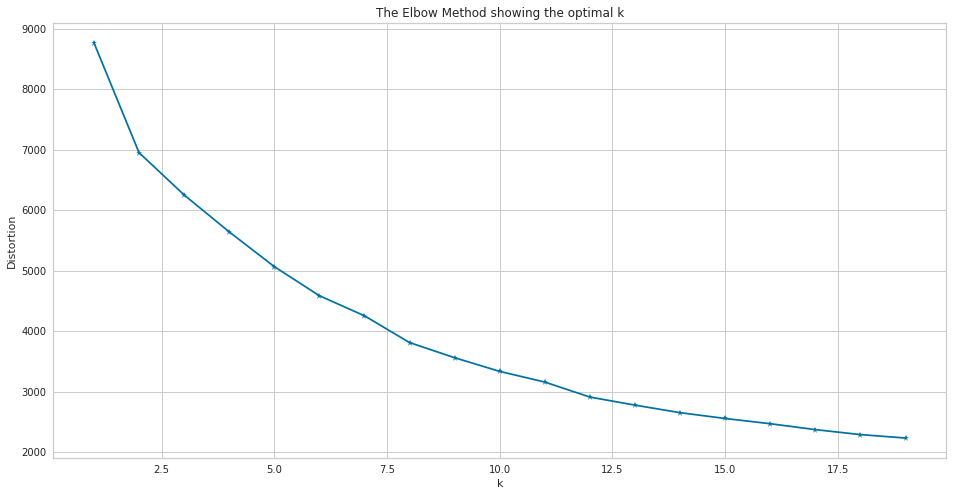

In [19]:
elbowKM(dfTSS, 20)

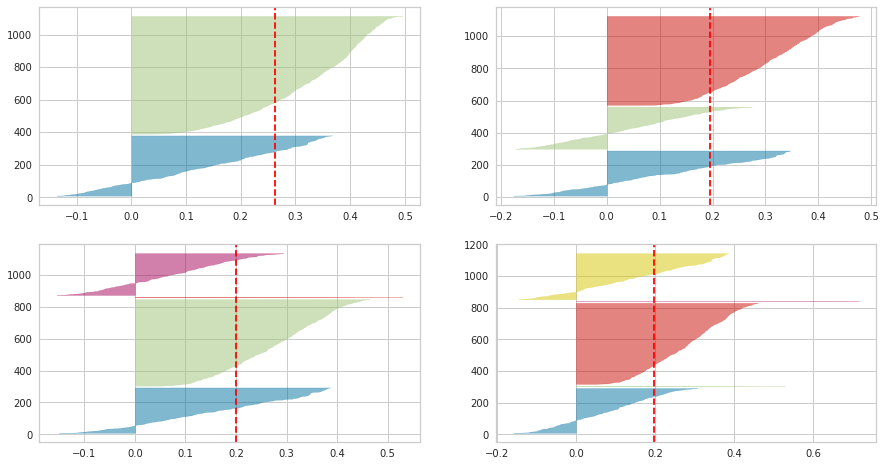

In [20]:
data = dfTSS
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data)

Видно, что оптимальное количество кластеров равно 2, но мы можем в целом не опираться на полученные результаты, руководствоваться только своим "экспертным" мнением. К тому же, в данных, очевидно, есть выбросы, алгоритм их учитывает.

In [21]:
dfTSS

,WinLose,xpRatio,kdRatio,kaRatio,hmRatio,khRatio,killstreak,scorePerMinute
0,-0.677816,-1.487312,-1.263441,-0.843142,-1.634888,-1.633899,-0.898904,-1.376926
1,1.492313,1.541006,0.770131,0.071223,1.207424,-0.230566,0.751960,0.922964
2,-0.710998,1.761756,-0.553361,0.866741,-0.598332,-0.510239,-0.532045,1.011371
3,0.104341,-0.941350,-0.746075,0.204219,-0.506612,-0.815959,0.293386,0.245674
4,0.070505,0.169175,0.678372,-0.090387,0.559401,-0.095346,1.485677,0.411771
...,...,...,...,...,...,...,...,...
1091,-0.526652,0.248879,0.384492,-0.443945,1.401173,-0.218961,-0.073472,1.410894
1092,-0.650164,-0.881513,0.023243,0.350828,0.764062,-1.174035,0.201672,0.306362
1093,0.914939,0.161526,-0.043827,0.126286,0.247823,0.113341,0.201672,1.287535
1094,2.002848,1.289368,0.806378,-0.208219,1.131442,0.248781,0.935389,0.555476


In [22]:
deleted_index = []
# dfTSS = dfTSS.drop(['Clusters'], axis=1) # при первом запуске закоомментировать, затем раcкомментироать и запустить снова
k_num = 20
c_num = 2  
alpha = 0.2 
min_k_len = 150 
porog = 150 
num_clust = 2

while True:
    not_deleted_index = [item for item in dfTSS.index if item not in deleted_index]
    clust = cureClustering(dfTSS.loc[not_deleted_index], k_num, c_num, alpha)
    err = []
    exit = 0
    for k in clust:
        if len(k) > porog:
            exit += 1
            continue
        if len(k) <= min_k_len:
            err.extend(k)
    if exit > num_clust or err == []:
        break
#     print(err)
    deleted_index.extend(err)
    
# find_emissions(dfTSS, 3)
deleted_index.extend(err)
not_deleted_index = [item for item in dfTSS.index if item not in deleted_index]

[271, 5, 233, 546, 3, 1, 1, 1, 5, 2, 16, 1, 1, 4, 1, 1, 1, 1, 1, 1]


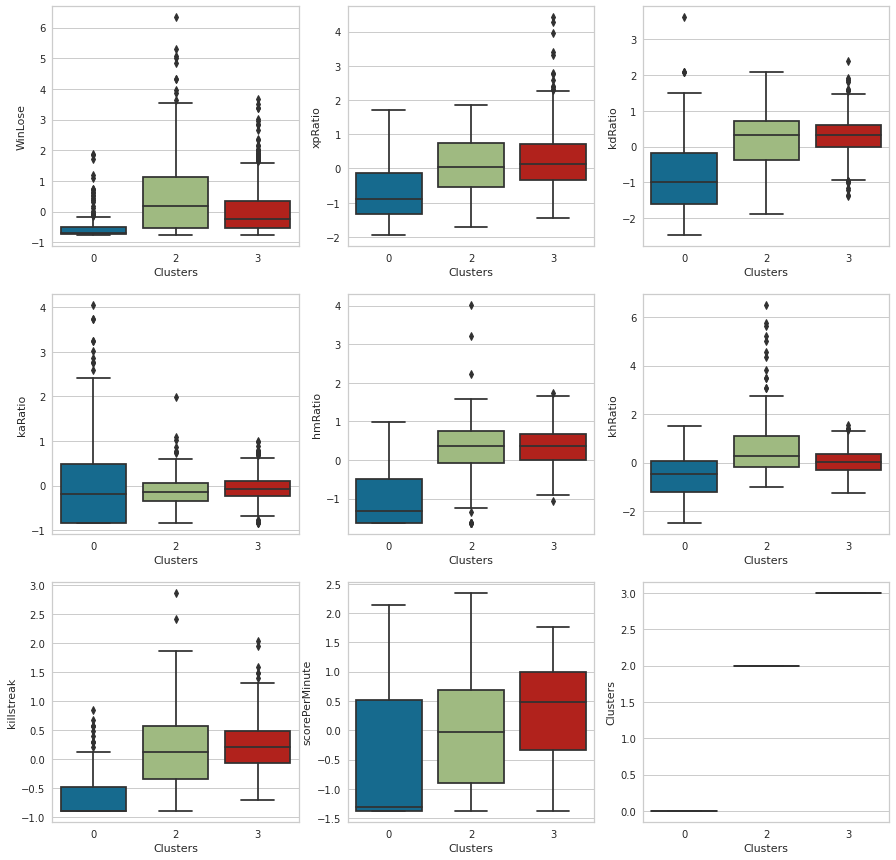

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
dfTSS['Clusters'] = -1
for i in range(20):
    dfTSS.loc[clust[i],'Clusters'] = i
i = 0

dfTSSClean = dfTSS.loc[not_deleted_index]
for column in dfTSSClean.columns.values:
    x, y = divmod(i, 3)
    axs[x,y].set_ylabel("values")
    axs[x,y].set_xlabel(column)    
    sns.boxplot(ax=axs[x,y], x=dfTSSClean['Clusters'],y=dfTSSClean[column],data=dfTSSClean)
    i += 1
plt.show()

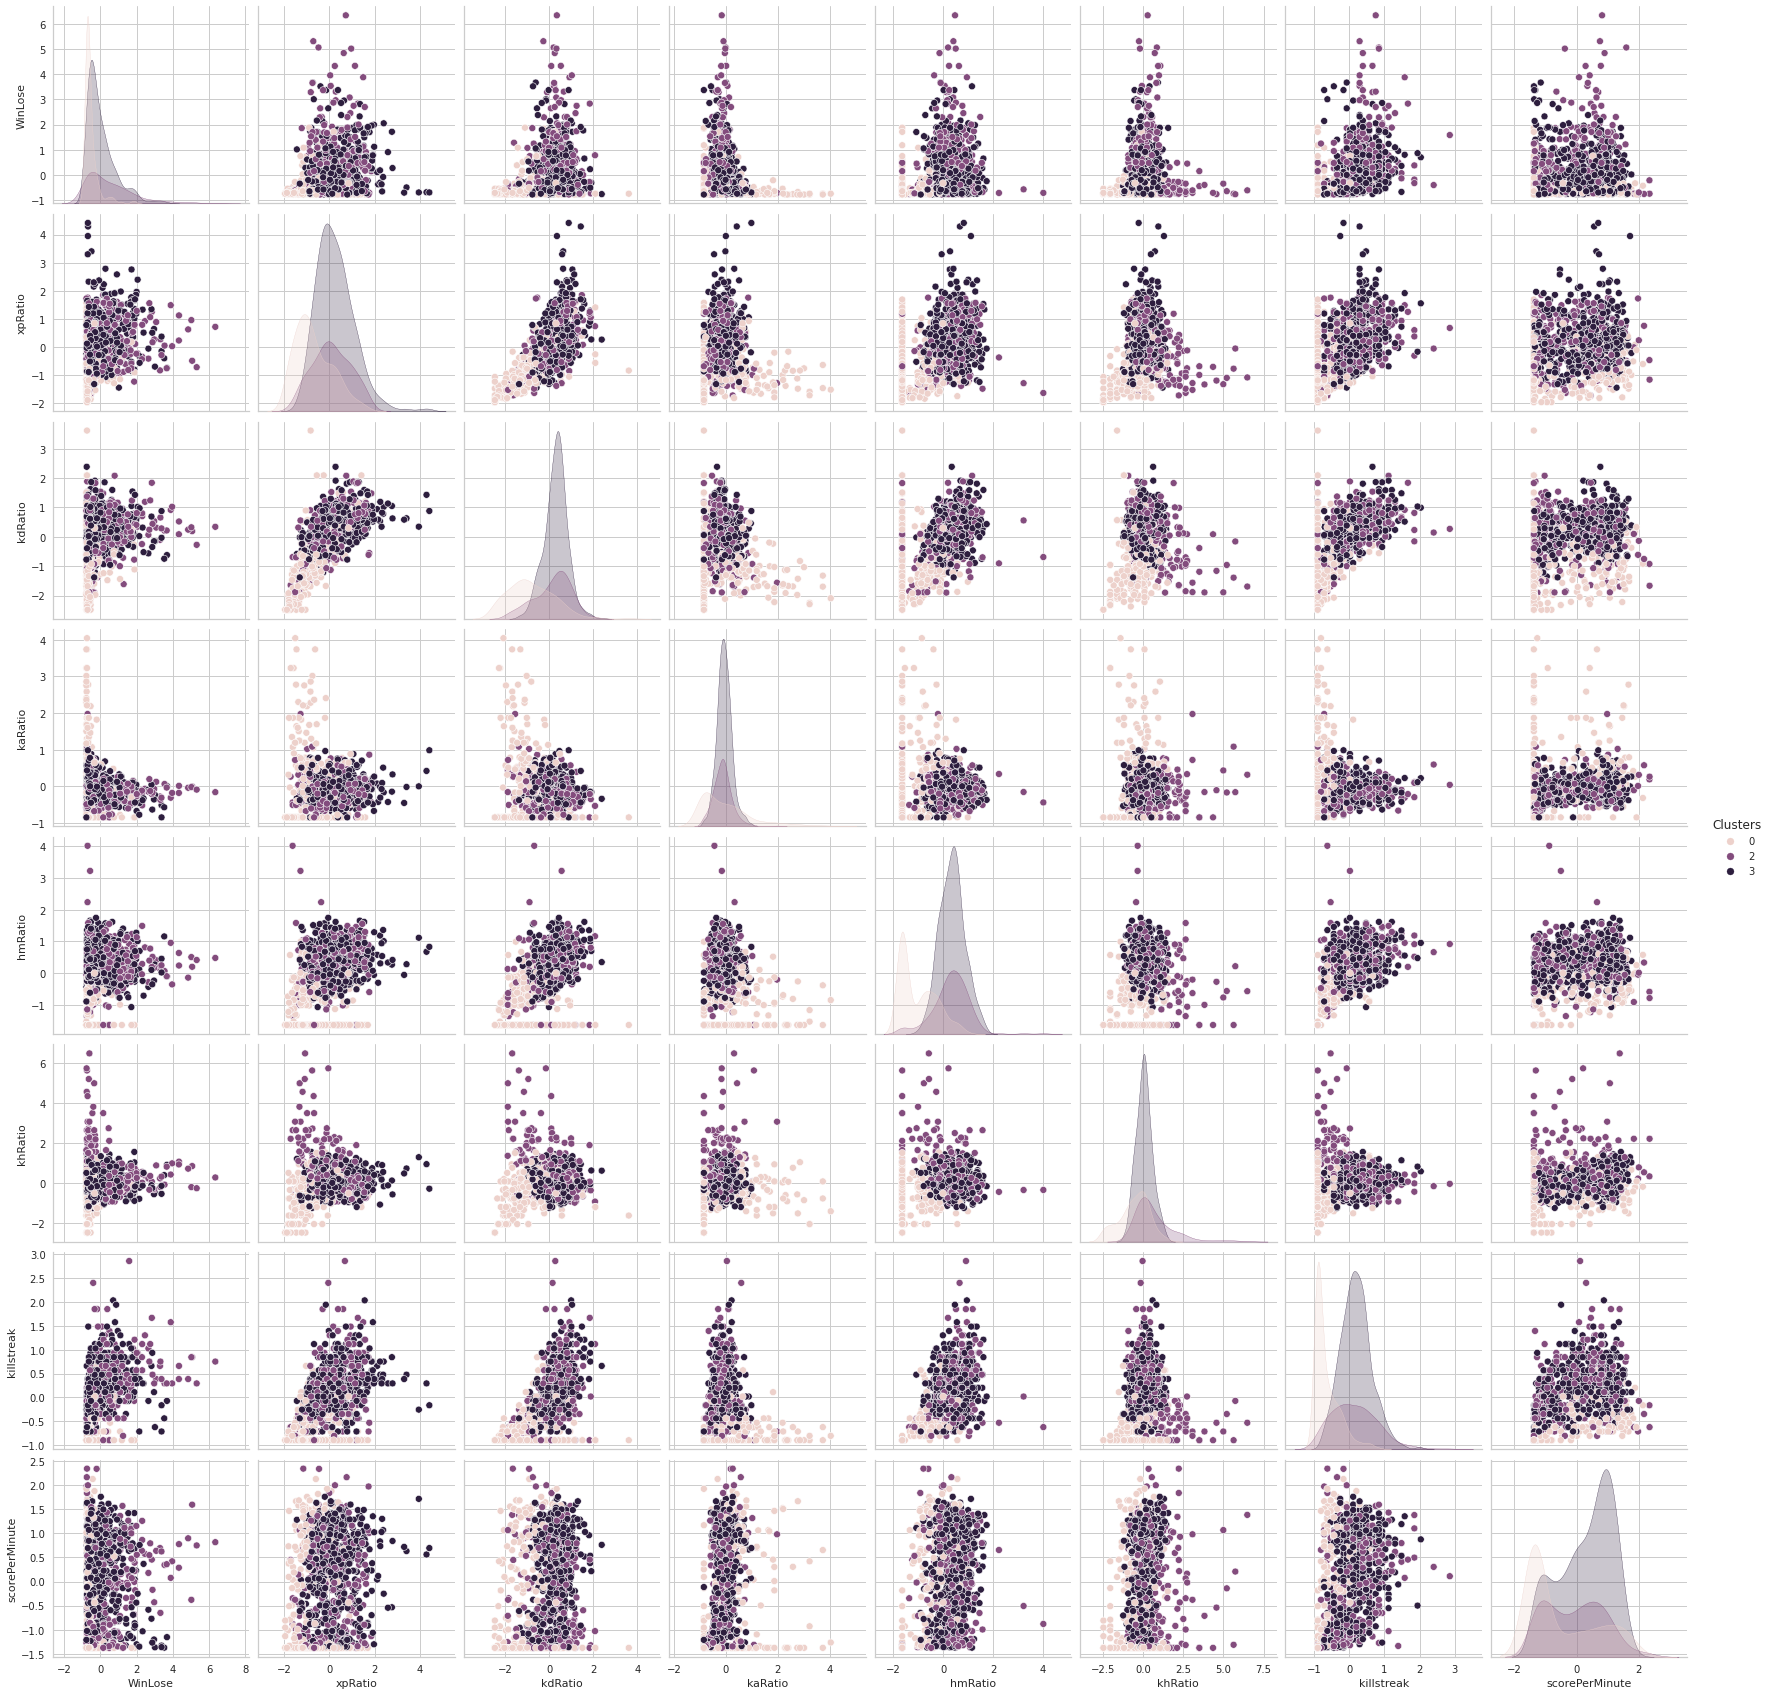

In [24]:
sns.set_style("whitegrid")
sns.pairplot(dfTSSClean, hue = 'Clusters', height=3);
plt.show()

### ВЫВОД
Выборка поделилась на 3 кластера, один из которых (3) в 2 раза больше двух остальных. Рассмотрим их в отдельности.

1. **Первый кластер -- "Слабые"**\
Всегда расположен относительно близко оси OX или OY.\
В этом кластере Самые низкие значения показателя WinLose, -- эти игроки больше проигрывают. Также они имеют низкие показатели по среднему кол-ву опыта в минуту, значит медленно прокачиваются. В целом, на этом моменте уже можно сказать, что это группа отстающих игроков. Кроме этого у них самая низкая скорость набора очков в мультиплеере, самые низкие показатели по клистрику, самый низкий khRatio (отнш. убийств к хедшотам), hmRatio (hits к misses) и kdRatio. Но kaRatio (kills к assists) выше, чем у остальных, также отмечено большое кол-во выбросов по этому показателю, значит в этом кластере присутсвуют игроки, которые сильно отличаются от остальной массы. 

Можно выделить типичных представителей этого кластера, если избавиться от записей, которые сильно отклоняются от среднего. 

In [25]:
df_cod.iloc[clust[0]].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,2.710000e+02,271.000000,271.000000,271.000000
mean,151.398524,3490.143911,0.646891,7.490775,42.424354,4.952030,48.154982,9543.073801,408.066421,576.118081,22.039959,111.110701,625.040590,42615.977860,7.946834e+05,117.086875,52159.051661,3668.778598
std,287.307507,6720.901188,0.408203,12.575067,62.940719,5.763993,51.938692,18127.431524,716.107903,1074.685064,77.417022,213.948148,1194.206385,78769.481346,1.524507e+06,119.439765,96220.739763,6833.207706
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,5.000000,0.281941,0.000000,2.000000,0.000000,0.000000,0.000000,7.500000,1.000000,2.059226,0.000000,0.000000,0.000000,3.912500e+03,0.000000,0.000000,18.500000
50%,10.000000,229.000000,0.754011,6.000000,11.000000,3.000000,13.000000,359.000000,52.000000,41.000000,3.041885,4.000000,44.000000,1912.000000,6.555000e+04,80.432078,2129.000000,291.000000
75%,177.000000,3583.500000,0.950404,12.000000,51.000000,9.000000,110.000000,9580.000000,457.500000,761.500000,8.000000,118.500000,648.500000,48205.500000,8.430970e+05,227.284268,60231.000000,3665.000000
max,1824.000000,34198.000000,1.910525,179.000000,287.000000,31.000000,113.000000,92828.000000,4356.000000,5734.000000,768.000000,1063.000000,6628.000000,402580.000000,8.658231e+06,362.015534,469693.000000,35976.000000


2. **Второй кластер -- "Средние и сильные одиночники"**\
Расположен в "ядре" распределения или дальше остальных от осей.\
Самый высокий: WinLose, khRatio, -- можно выдвинуть гипотезу, что эти игроки совершают длительные серии убийств, килстрик у данного показателя чуть ниже, чем у 3 кластера (возможно из-за того, что минимальное значение достаточно отличается, + в 3 кластере есть выбросы по данному показателю), но гораздо выше, чем у 1.\
Относительно 3 кластера имеет низкие показатели по скорости набора очков в матче. 

В целом, в этот кластер попали те, кто меньше играет в мультиплеер, чем одиночный режим. Результаты, которые заполняются по итогам матчей, высокие, поэтому скорее всего, их просто меньше.

In [26]:
df_cod.iloc[clust[2]].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,2.330000e+02,233.000000,233.000000,233.000000
mean,107.892704,2677.776824,0.597214,5.896996,34.012876,4.768240,43.566524,8171.459227,314.278970,465.206009,21.646506,85.463519,539.171674,34635.961373,6.021530e+05,97.153137,42807.420601,2808.978541
std,219.533207,6328.901681,0.427227,7.188211,54.913214,8.425506,50.788406,20047.089577,615.103408,1057.994859,78.013965,196.165372,1343.999636,83876.664313,1.283502e+06,116.765918,102988.738496,6494.487539
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.181818,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.909091,0.000000,0.000000,0.000000,1.605000e+03,0.000000,0.000000,9.000000
50%,6.000000,106.000000,0.663830,3.000000,7.000000,2.000000,6.000000,57.000000,31.000000,16.000000,3.000000,1.000000,21.000000,377.000000,3.456300e+04,23.100000,476.000000,153.000000
75%,108.000000,1832.000000,0.939394,10.000000,41.000000,7.000000,110.000000,4658.000000,314.000000,284.000000,8.250000,53.000000,334.000000,20788.000000,5.518740e+05,208.717391,25080.000000,2153.000000
max,1210.000000,44067.000000,2.000000,41.000000,277.000000,80.000000,113.000000,132368.000000,3782.000000,7709.000000,728.000000,1160.000000,9598.000000,558604.000000,8.216452e+06,413.346108,622347.000000,48819.000000


3. **Третьий кластер -- "Средний и сильный мультиплеер"**\
Самый многочисленный, расположение объектов мало отличается от предыдущего кластера, кроме уже упомянутых отличительных фичей.\
Имеет хорошие показатели по WinLose и khRatio (относительно других кластеров средние).\
Самые высокие scorePerMinute и xpRatio, хорошие и более менее стабильные килстрик, hmRatio и kdRatio; kaRatio чуть выше, чем у остальных.

На мой взгляд, это группа хороших игроков. По крайней мере судя по медианным значениям престижа, у этой группы самый высокий показатель.

In [27]:
df_cod.iloc[clust[3]].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.00000,546.000000,546.000000,546.000000,546.000000,5.460000e+02,546.000000,5.460000e+02,546.000000
mean,159.379121,3956.653846,0.639157,7.135531,48.001832,5.199634,52.038462,10811.492674,451.058608,660.53663,26.344131,124.210623,729.976190,47458.564103,9.599262e+05,101.962905,5.826979e+04,3995.362637
std,314.328422,8072.965514,0.432110,12.283947,72.233325,7.435501,52.393609,24229.917227,815.803102,1338.81789,102.168101,288.057814,1600.049855,103057.621400,1.955912e+06,113.306195,1.266763e+05,7868.303249
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000,3.000000,0.258889,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,1.00000,2.000000,0.000000,0.000000,0.000000,1.637500e+03,0.000000,0.000000e+00,13.250000
50%,10.000000,241.500000,0.741197,5.000000,13.000000,3.000000,23.500000,231.000000,67.500000,41.00000,3.192262,3.000000,48.500000,1447.500000,8.190300e+04,50.135053,1.706000e+03,350.000000
75%,192.250000,3515.250000,0.961492,12.000000,53.000000,8.000000,110.000000,9842.500000,535.750000,596.50000,10.000000,119.750000,675.750000,44070.500000,9.115740e+05,205.086136,5.575125e+04,3907.250000
max,3519.000000,59563.000000,2.280000,235.000000,433.000000,53.000000,113.000000,209851.000000,7479.000000,11719.00000,1349.000000,3745.000000,14531.000000,965775.000000,1.488843e+07,413.800000,1.166620e+06,67888.000000


/tmp/ipykernel_492/1142349772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cod['Clusters'].loc[deleted_index] = -1


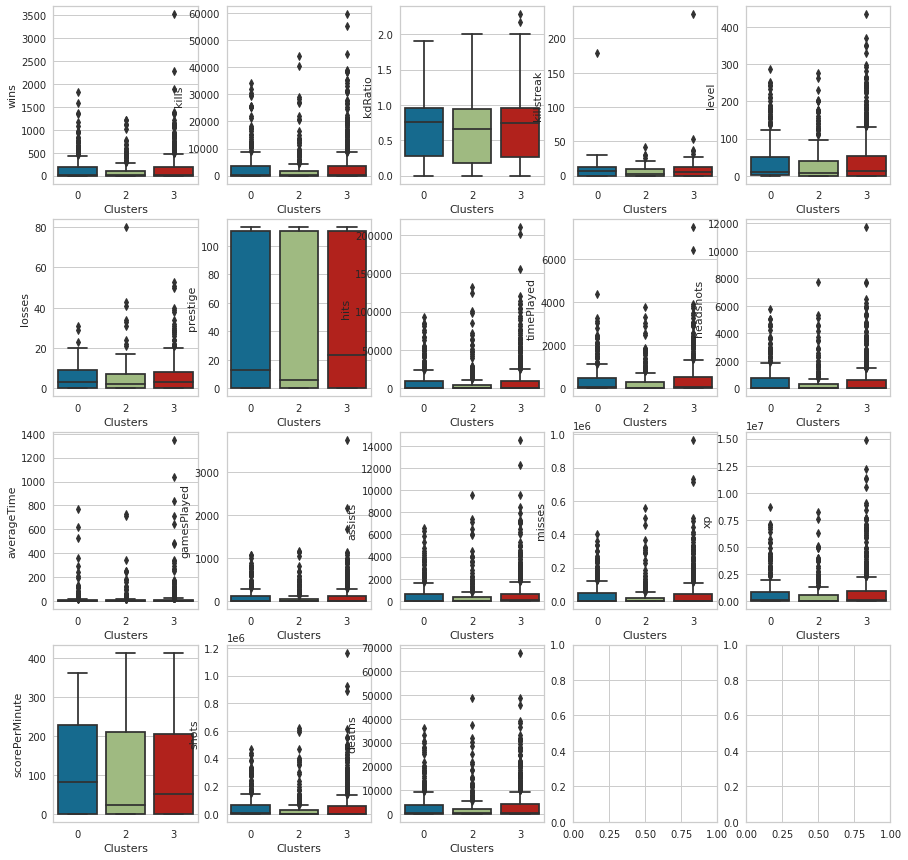

In [28]:
fig, axs = plt.subplots(4, 5, figsize=(15,15))
df_cod['Clusters'] = -1
for i in range(20):
    df_cod.loc[clust[i],'Clusters'] = i
df_cod['Clusters'].loc[deleted_index] = -1
i = 0

dfCodeClean = df_cod.loc[not_deleted_index]
for column in dfCodeClean.columns.values:
    if column == 'name' or column == 'Clusters':
        continue
    x, y = divmod(i, 5)
    axs[x,y].set_ylabel("values")
    axs[x,y].set_xlabel(column)    
    sns.boxplot(ax=axs[x,y], x=dfCodeClean['Clusters'],y=dfCodeClean[column],data=dfCodeClean)
    i += 1
plt.show()

In [29]:
df_cl0 = df_cod.iloc[clust[0]]
df_cl0[(df_cl0['prestige'] > 10)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths,Clusters
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,1.420000e+02,142.000000,142.000000,142.000000,142.0
mean,270.845070,6340.943662,0.814189,10.852113,74.316901,7.485915,91.056338,17089.070423,738.091549,1045.830986,34.208680,197.359155,1133.640845,76565.556338,1.462352e+06,126.529157,93654.626761,6641.330986,0.0
std,353.612588,8255.290450,0.328685,16.092793,72.968017,6.102826,35.594600,22193.883430,858.914207,1308.190245,101.722914,261.400384,1465.627077,95852.707300,1.866951e+06,111.733212,116992.514170,8344.137278,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0
25%,6.250000,154.500000,0.674767,1.250000,12.250000,1.250000,100.000000,8.500000,68.750000,28.000000,2.644608,0.000000,44.250000,85.000000,7.468400e+04,1.749206,93.500000,264.500000,0.0
50%,116.000000,3028.000000,0.864759,10.000000,47.000000,7.500000,110.000000,6858.500000,419.500000,499.500000,4.000000,77.000000,492.500000,31982.000000,7.177625e+05,125.858781,39706.500000,3099.000000,0.0
75%,434.250000,9069.750000,0.986993,15.000000,132.500000,11.000000,111.000000,27442.750000,1153.000000,1584.500000,22.932692,292.750000,1604.000000,127286.000000,2.219402e+06,221.084384,158888.500000,10278.250000,0.0
max,1824.000000,34198.000000,1.910525,179.000000,287.000000,31.000000,113.000000,92828.000000,4356.000000,5734.000000,768.000000,1063.000000,6628.000000,402580.000000,8.658231e+06,348.844444,469693.000000,35976.000000,0.0


In [30]:
df_cl2 = df_cod.iloc[clust[2]]
df_cl2[(df_cl2['prestige'] > 10)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths,Clusters
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,1.110000e+02,111.000000,111.000000,111.000000,111.0
mean,209.297297,5354.585586,0.815986,9.441441,64.792793,7.918919,90.459459,16270.630631,622.297297,930.936937,39.310907,165.657658,1076.198198,68788.099099,1.212104e+06,118.470433,85058.729730,5568.324324,2.0
std,282.709700,8376.178360,0.326293,7.967759,66.557851,10.231978,34.600521,26742.341617,778.834906,1388.913436,109.961203,258.436153,1796.844450,111760.232623,1.654777e+06,114.877739,137031.121079,8576.040982,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.0
25%,0.000000,168.500000,0.679121,0.000000,9.500000,1.000000,73.500000,0.000000,52.500000,34.000000,2.530178,0.000000,24.500000,0.000000,4.918500e+04,0.000000,0.000000,219.500000,2.0
50%,99.000000,1681.000000,0.892523,10.000000,41.000000,6.000000,110.000000,3738.000000,314.000000,278.000000,4.307692,34.000000,280.000000,16224.000000,5.588720e+05,98.613610,21025.000000,1885.000000,2.0
75%,297.000000,7040.000000,1.010038,14.000000,110.500000,11.000000,111.000000,21328.500000,941.000000,1167.000000,18.187500,226.500000,1223.500000,85241.000000,1.723100e+06,225.597425,102827.000000,7109.000000,2.0
max,1210.000000,44067.000000,1.777778,41.000000,277.000000,80.000000,113.000000,132368.000000,3782.000000,7709.000000,728.000000,1160.000000,9598.000000,558604.000000,8.216452e+06,413.346108,622347.000000,48819.000000,2.0


In [31]:
df_cl3 = df_cod.iloc[clust[3]]
df_cl3[(df_cl3['prestige'] > 10)].describe()

,wins,kills,kdRatio,killstreak,level,losses,prestige,hits,timePlayed,headshots,averageTime,gamesPlayed,assists,misses,xp,scorePerMinute,shots,deaths,Clusters
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300.000000,3.000000e+02,300.00000,300.0
mean,264.523333,6650.650000,0.829057,10.370000,79.783333,7.873333,94.066667,17955.723333,766.530000,1108.946667,42.779834,207.073333,1224.543333,78740.303333,1.661734e+06,111.181360,9.669555e+04,6681.63000,3.0
std,385.488835,9867.218848,0.327350,15.219457,83.150324,8.629727,32.653582,30122.353426,981.673036,1632.110665,133.995441,362.048373,1985.874464,127924.284590,2.403643e+06,102.841283,1.571740e+05,9596.35054,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000,3.0
25%,1.000000,152.250000,0.687602,0.000000,14.750000,1.000000,110.000000,0.000000,78.500000,33.500000,2.721667,0.000000,37.000000,0.000000,9.850625e+04,0.019937,0.000000e+00,251.50000,3.0
50%,127.000000,2537.500000,0.895924,10.000000,46.000000,6.000000,110.000000,6001.000000,422.500000,425.000000,5.000000,69.000000,410.500000,23881.500000,6.762955e+05,103.172482,2.959200e+04,2730.00000,3.0
75%,378.500000,9096.500000,1.000000,15.000000,134.250000,10.000000,111.000000,22237.500000,1072.500000,1508.500000,24.062399,251.500000,1556.500000,101967.500000,2.258674e+06,199.938359,1.243692e+05,9858.50000,3.0
max,3519.000000,59563.000000,2.171183,235.000000,433.000000,53.000000,113.000000,209851.000000,7479.000000,11719.000000,1349.000000,3745.000000,14531.000000,965775.000000,1.488843e+07,330.616205,1.166620e+06,67888.00000,3.0


## 3 ВЫВОД ПО КЛАСТЕРИЗАЦИИ

**Оценка работы**\
Кластеры получились смешаными, алгоритму свойственно выделение в отдельные кластеры тех объектов, которые расположены близко, не смотря на их принадлежность другим группам. 

Возникли проблемы, связанные с опытом игры в мультиплеер. Возможно, этот показатель стоило бы включить в модель. В целом, гипотеза о том, что престиж можно использовать как отражение мастерства, подтвердилась.

Также, можно было бы попробовать лучше подобрать параметры, удалять выбросы, разделить выборку по прниципу опыта участия в матчах. 

Или совсем иной подход -- не удалять пользователей, которые не играли в мультиплеер, а не использовать фичи, которые мультиплеер заполняет.

**Подведение итогов по кластерам**\
Итак, чтобы разделить игроков по уровню способностей нельзя обращать внимание на статистику в чистом виде. Из-за системы интеграции сезонных званий любой опытный игрок вполне может иметь низкий уровень и небольшое количество времени, проведенного в игре, следовательно и низкие показатели по статистике.

Но почти все опытные игроки имеют престиж, а самые хорошие имеют высокий престиж. Поэтому значение престижа вполне можно использовать, как один из критериев выявления хороших игроков, но не единственный, -- не все игроки с хорошим уровнем престижа имеют хорошую статистику. Их стоит также подразделять на внутренние подгруппы. В целом, сделать какое-то четкое описание кластеров сложно, потому что они перекрывают друг друга. Только кластер слабых игроков интерпретируется однозначно, это игроки, у которых показатели всех фичей ниже остальных. При этом и среди них есть представители высоких уровней, пользователи, которые играли по времени также много, как и представители более сильных кластеров (следовательно и статистика исходного датасета у них будет такая же высокая). 

Т.о. подбирая игроков для команд стоит обращать внимание не только на престиж, стоит брать во внимание также уровень и статистику. В силу разных обстоятельств игроки с высоким престижем не могут играть на рассматриваемой платформе на высоком уровне. Это может быть связано с когнитивными сторонами, с новым оружием, внутренним устройством игрового сообщества и так далее, -- все это делает игрока нерезультативным. Но в целом, кончено, лучше всего проявляют себя опытные игроки (большой престиж, большее время, много очков опыта, высокая скорость набора очков и тд)

В целом, чтобы команда была сбалансированной, в ней должны быть представители всех выделенных кластеров.

## 4 КЛАССИФИКАЦИЯ

Методы, реализованные в данном разделе, не несут в себе никакой практической ценности, так как все построения происходят на основе результатов, полученных в результате не очень качественной кластеризации. Каким бы точным ни был метод, он всегда будет предсказывать значения, которые изначально были не совсем точными. Если бы была метрика, которая дана изначально, или для обучающей выборки использовались бы типичные представители кластеров, некие центроиды, то результаты были бы иными.

В данном датафрейме содержится информация об объектах, кластерах и их соответсвии. Выбросов нет. 

In [32]:
dfTSSClean

,WinLose,xpRatio,kdRatio,kaRatio,hmRatio,khRatio,killstreak,scorePerMinute,Clusters
0,-0.677816,-1.487312,-1.263441,-0.843142,-1.634888,-1.633899,-0.898904,-1.376926,0
1,1.492313,1.541006,0.770131,0.071223,1.207424,-0.230566,0.751960,0.922964,3
2,-0.710998,1.761756,-0.553361,0.866741,-0.598332,-0.510239,-0.532045,1.011371,2
3,0.104341,-0.941350,-0.746075,0.204219,-0.506612,-0.815959,0.293386,0.245674,0
4,0.070505,0.169175,0.678372,-0.090387,0.559401,-0.095346,1.485677,0.411771,2
...,...,...,...,...,...,...,...,...,...
1091,-0.526652,0.248879,0.384492,-0.443945,1.401173,-0.218961,-0.073472,1.410894,3
1092,-0.650164,-0.881513,0.023243,0.350828,0.764062,-1.174035,0.201672,0.306362,3
1093,0.914939,0.161526,-0.043827,0.126286,0.247823,0.113341,0.201672,1.287535,3
1094,2.002848,1.289368,0.806378,-0.208219,1.131442,0.248781,0.935389,0.555476,2


Далее несколько методов будет использовано для пресказания одного из объектов. На основе их точностей будет выбран тот, который будет использоваться для предсказания классов всех объектов.  

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

dfTSSClean = dfTSSClean.sample(frac=1)
Xdf = dfTSSClean[clusterColumns]
Ydf = dfTSSClean['Clusters']
X_train, X_test, y_train, y_test = train_test_split(Xdf, Ydf, test_size=0.20, random_state = 1)
    
data = [[-0.67, -1.4, -1.26,-0.84, -1.63, -1.63,-0.89,-1.37 ]]

classificators = [
    ensemble.RandomForestClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    LogisticRegression(max_iter=10000)]

for classificator in classificators:
    accuracy_percent(X_train, y_train, X_test, y_test, classificator)
    print('\n')

RandomForestClassifier()
Score is 100.0%


GradientBoostingClassifier()
Score is 96.54761904761905%


BaggingClassifier()
Score is 99.40476190476191%


ExtraTreesClassifier()
Score is 100.0%


LogisticRegression(max_iter=10000)
Score is 78.33333333333333%




Самым точным оказался ExtraTreesClassifier, будем его использовать.

In [34]:
classifier = ensemble.ExtraTreesClassifier()
classifier.fit(Xdf,Ydf)
y_pred = classifier.predict(dfTSS[clusterColumns])

In [35]:
dfTSS['Cluster'] = y_pred

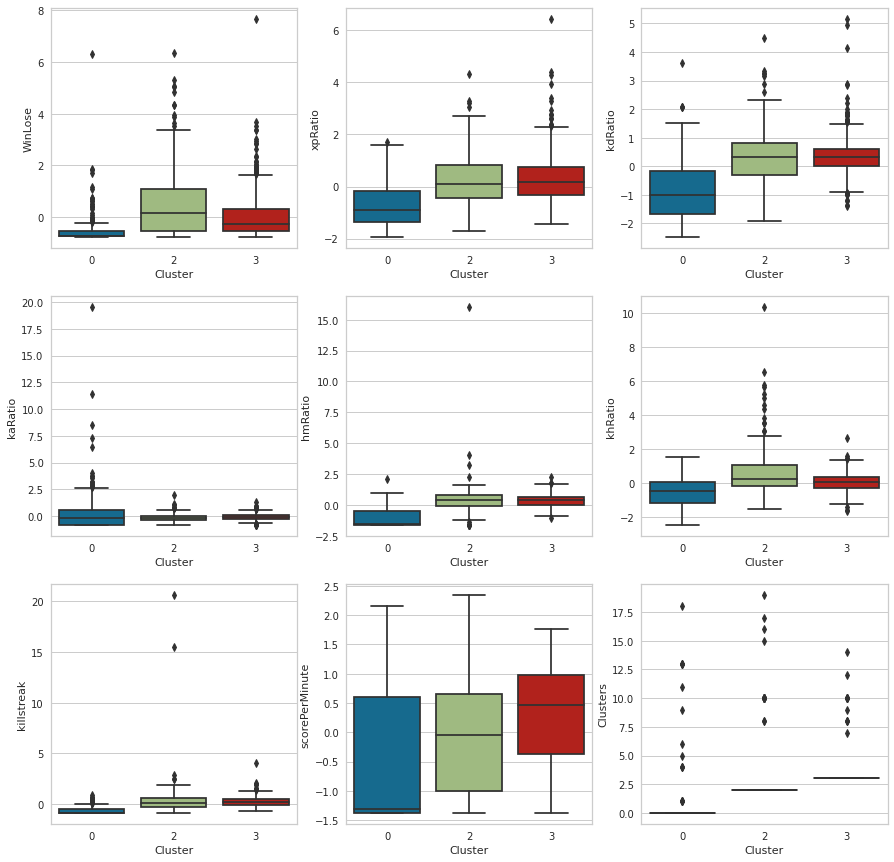

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
i = 0
dfTSSClean = dfTSS
for column in dfTSSClean.columns.values:
    if column == 'Cluster':
        continue
    x, y = divmod(i, 3)
    axs[x,y].set_ylabel("values")
    axs[x,y].set_xlabel(column)    
    sns.boxplot(ax=axs[x,y], x=dfTSSClean['Cluster'],y=dfTSSClean[column],data=dfTSSClean)
    i += 1
plt.show()

## 4 ВЫВОД

Метод классификации очень точно предсказал предсказанные кластеры. В целом, если данных достаточно чтобы использовать алгоритм обучения с учителем, то лучше отдать предпочтение ему, нежели алгоритмам без учителя.

In [37]:
len(deleted_index)

46

идеи для более нормального разбиения:
1. придумать алгоритм для подбора параметров в cure
2. кластеризовать схожие кластеры по отдельности, например, из двух кластеров со средними и сильными игроками можно было бы попробовать получить 3 или 2 более четких